# UMAP ( Uniform Manifold Approximation )
### for dimentionality reduction

In [ ]:
import umap

In [ ]:
from sklearn.datasets import load_digits

In [2]:
digits = load_digits()

embedding = umap.UMAP().fit_transform(digits.data)

In [14]:
digits.data.shape

(1797, 64)

In [7]:
embedding.shape

(1797, 2)

In [9]:
import seaborn as sn
import matplotlib.pyplot as plt


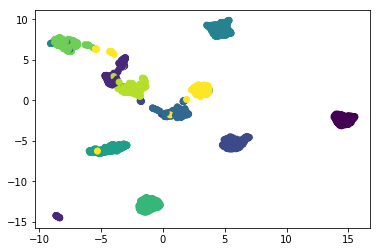

In [19]:

plt.scatter(embedding[:,0],y = embedding[:,1] , c = digits.target)

# Embedding of prime numbers' binary vectors  
each number is represented by a vector of size n , where n are the first n prime numbers. the vector has a 1 if the prime number is present in the prime factortisation of the number


In [3]:
# %load umap_sparse.py
### JHW 2018
import numpy as np
import umap

In [4]:
# This code from the excellent module at:
# https://stackoverflow.com/questions/4643647/fast-prime-factorization-module
    
import random

In [5]:
_known_factors = {}  
totients = {}

In [6]:
def primesbelow(N):
    # http://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n-in-python/3035188#3035188
    """ Input N>=6, Returns a list of primes, 2 <= p < N """
    correction = N % 6 > 1
    N = {0:N, 1:N-1, 2:N+4, 3:N+3, 4:N+2, 5:N+1}[N%6]
    sieve = [True] * (N // 3)
    sieve[0] = False
    for i in range(int(N ** .5) // 3 + 1):
        if sieve[i]:
            k = (3 * i + 1) | 1
            sieve[k*k // 3::2*k] = [False] * ((N//6 - (k*k)//6 - 1)//k + 1)
            sieve[(k*k + 4*k - 2*k*(i%2)) // 3::2*k] = [False] * ((N // 6 - (k*k + 4*k - 2*k*(i%2))//6 - 1) // k + 1)
    return [2, 3] + [(3 * i + 1) | 1 for i in range(1, N//3 - correction) if sieve[i]]

In [7]:

smallprimeset = set(primesbelow(1000000))
_smallprimeset = 1000000

Wall time: 0 ns


In [18]:
len(smallprimeset) 

78498

In [13]:
%time
smallprimes = primesbelow(10000000) 
prime_ix = {p:i for i,p in enumerate(smallprimes)}

Wall time: 0 ns


In [19]:
prime_ix[23]

8

In [20]:
def isprime(n, precision=7):
    # http://en.wikipedia.org/wiki/Miller-Rabin_primality_test#Algorithm_and_running_time
    if n < 1:
        raise ValueError("Out of bounds, first argument must be > 0")
    elif n <= 3:
        return n >= 2
    elif n % 2 == 0:
        return False
    elif n < _smallprimeset:
        return n in smallprimeset


    d = n - 1
    s = 0
    while d % 2 == 0:
        d //= 2
        s += 1

    for repeat in range(precision):
        a = random.randrange(2, n - 2)
        x = pow(a, d, n)

        if x == 1 or x == n - 1: continue

        for r in range(s - 1):
            x = pow(x, 2, n)
            if x == 1: return False
            if x == n - 1: break
        else: return False

    return True

In [21]:
# https://comeoncodeon.wordpress.com/2010/09/18/pollard-rho-brent-integer-factorization/
def pollard_brent(n):
    if n % 2 == 0: return 2
    if n % 3 == 0: return 3

    y, c, m = random.randint(1, n-1), random.randint(1, n-1), random.randint(1, n-1)
    g, r, q = 1, 1, 1
    while g == 1:
        x = y
        for i in range(r):
            y = (pow(y, 2, n) + c) % n

        k = 0
        while k < r and g==1:
            ys = y
            for i in range(min(m, r-k)):
                y = (pow(y, 2, n) + c) % n
                q = q * abs(x-y) % n
            g = gcd(q, n)
            k += m
        r *= 2
    if g == n:
        while True:
            ys = (pow(ys, 2, n) + c) % n
            g = gcd(abs(x - ys), n)
            if g > 1:
                break

    return g

    

In [22]:
def _primefactors(n, sort=False):
    factors = []

    for checker in smallprimes:
        while n % checker == 0:
            factors.append(checker)
            n //= checker
            # early exit memoization
            if n in _known_factors:
                return factors + _known_factors[n]
        if checker > n: break

    if n < 2: return factors

    while n > 1:
        if isprime(n):
            factors.append(n)
            break
        factor = pollard_brent(n) # trial division did not fully factor, switch to pollard-brent
        factors.extend(primefactors(factor)) # recurse to factor the not necessarily prime factor returned by pollard-brent
        n //= factor

    if sort: factors.sort()

    return factors

In [23]:
def primefactors(n, sort=False):
    if n in _known_factors:
        return _known_factors[n]
    
    result = _primefactors(n)
    _known_factors[n] = result
    return result

from collections import defaultdict

In [24]:
def factorization(n):
    factors = defaultdict(int)
    for p1 in primefactors(n):
        factors[p1] += 1        
    return factors

In [25]:
def unique_factorise(n):
    return set(primefactors(n))

In [26]:
def totient(n):
    if n == 0: return 1

    try: return totients[n]
    except KeyError: pass

    tot = 1
    for p, exp in factorization(n).items():
        tot *= (p - 1)  *  p ** (exp - 1)

    totients[n] = tot
    return tot

In [27]:
def gcd(a, b):
    if a == b: return a
    while b > 0: a, b = b, a % b
    return a

In [28]:
def lcm(a, b):
    return abs((a // gcd(a, b)) * b)

In [29]:
### end



## Create sparse binary factor vectors for any number, and assemble into a matrix
## One column for each unique prime factor
## One row for each number, 0=does not have this factor, 1=does have this factor (might be repeated)

from scipy.special import expi
import scipy.sparse

In [30]:
def factor_vector_lil(n):
    ## approximate prime counting function (upper bound for the values we are interested in)
    ## gives us the number of rows (dimension of our space)
    d = int(np.ceil(expi(np.log(n))))    
    x = scipy.sparse.lil_matrix((n,d))
    for i in range(2,n):                                          
        for k,v in factorization(i).items():            
            x[i,prime_ix[k]] = 1
                    
        if i%100000==0: # just check it is still alive...
            print(i)        
    return x

In [34]:
### Generate the matrix for 1 million integers

n = 10000
X = factor_vector_lil(n) 

In [35]:
# embed with UMAP
embedding = umap.UMAP(metric='cosine', n_epochs=500).fit_transform(X)

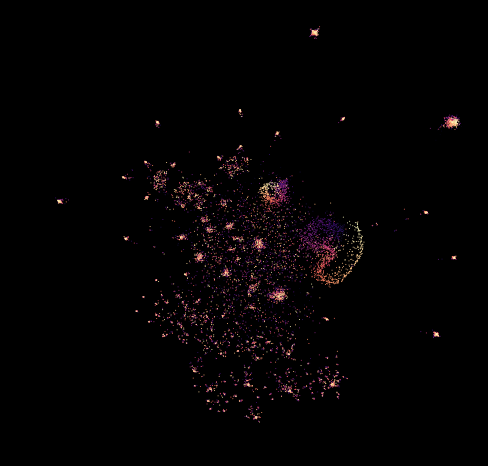

In [37]:
# save for later
np.savez('1e6_pts.npz', embedding=embedding)


# and save the image
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor('black')
plt.scatter(embedding[:,0], embedding[:,1], marker='o', s=1, edgecolor='',
            c=np.arange(n), cmap="magma")

plt.axis("off")
plt.savefig("primes_umap_1e6_16k_smaller_pts.png", dpi=2000, facecolor='black')